# Text Analytics: Sentiment Analysis of Products Review on Amazon

# Processing pipeline
* Evaluation strategy: N*K-fold Cross Validation (CV)
* Feature extraction: TF-IDF vectorization
* Feature oversampling: Synthetic Minority Oversampling Technique (SMOTE)
* Classifiers: Naive Bayes (NB), Logistic Regression (LR), and Support Vector Machine (SVM, Linear)
* Validation metrics: 
 * One-vs-Rest (OvR) binary Receiver Operating Characteristic (ROC) curve + their macro-average across repetitions;
 * Area under the ROC Curve (AUC);
 * G-mean;
 * True Positive Rate (TPR), Positive Predictive Value (PPV), F1 score, Accuracy (ACC);
 * One-vs-Rest (OvR) binary confusion matrix;
 * Multiclass confusion matrix.
 

## Table of Contents

* [Libraries](#section1)
* [Dataset](#section1)

# Libraries <a class="anchor" id="section1"></a>

In [1]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
import sys
import wordcloud # pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
# from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import re

# sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV #, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# scipy
from scipy import interp

# imblearn
from imblearn.over_sampling import SMOTE # conda install -c conda-forge imbalanced-learn
# from imblearn.combine import SMOTETomek # pip install -U imbalanced-learn
from imblearn.pipeline import make_pipeline, Pipeline
# from imblearn.under_sampling import NearMiss

# Utility
import math
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
from collections import Counter, defaultdict, Sequence
from itertools import cycle, combinations, chain
from IPython.display import clear_output

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset <a class="anchor" id="section2"></a>
[About dataset](https://www.kaggle.com/datasets/nehaprabhavalkar/indian-products-on-amazon)

In [2]:
data = pd.read_csv('../input/indian-products-on-amazon/amazon_vfl_reviews.csv' ,encoding='latin', names = ['asian','name','date','rating','text'], skiprows=1) # encoding="UTF-8". skiprows=1: Skips the first row from top in the csv file
data.head(3)

,asian,name,date,rating,text
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...


# Data size

In [3]:
reviewColName = 'text' # Better programming practice: The name of review column is stored in a variable, so that in other dataset with different column name it is only enough to change this variable
ratingColName = 'rating' # Better programming practice:
ratingOrigColName = ratingColName+'Orig'
clfParamName = 'clf' # common word used in param_grid & Pipeline
n_splits = 3 #4 Fold number in K-fold CV
n_repeats = 2 #10: Number of repetitions of cross-validation
random_state = 0
print('Rows nb: {}\nColumns nb: {}\nColumn names: {}'.format(data.shape[0], data.shape[1], (', ').join(list(data.columns)))) # Displays the size of the data

Rows nb: 2782
Columns nb: 5
Column names: asian, name, date, rating, text


# Data wrangling:
* Removing rows containing NA/NAN values;
* Removes non-word text tokens (HTML markup, emoticons, ...);
* Stem of text tokens;
* Removing stop-words text tokens.

In [4]:
def na_remover(dfIn):
    """Removes rows containing NA/NAN values"""
    dfOut = dfIn.dropna()
    print("{} rows containing NA/NAN were removed.".format(dfIn.shape[0] - dfOut.shape[0]))
    return dfOut


def nonWord_remover(textIn):
    """Removes non-word text tokens"""
    textOut = re.sub('<[^>]*>', '', textIn) # Removes all of the HTML markup from the reviews.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', textOut) # Finds emoticons
    textOut = (re.sub('[\W]+', ' ', textOut.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
    return textOut


porter = PorterStemmer()
def word_stemmer(textIn):
    """Stem of text tokens"""
    textOut = [porter.stem(word) for word in textIn.split()]
    return textOut


stopWords = stopwords.words('english')+['product', 'thi', 'à', 'the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
def stopWords_remover(textIn):
    """Removes stop-words text tokens"""
    textOut = ' '.join([word for word in textIn if word not in stopWords])
    return textOut


def mostCommonWords_finder(df, N, lenMin):
    """Finds the most common N words of minimum length of lenMin"""
    all_words = []
    for line in list(df):
        words = line.split()
        for word in words:
          if (len(word) > lenMin):
            all_words.append(word.lower()) 
    return Counter(all_words).most_common(N)


def wrangler(dfIn, textColumn):
    """Removes NA/NAN values & non-word & stop-words text tokens"""
    dfOut = na_remover(dfIn) # Removes rows containing NA/NAN values
    dfOut[textColumn] = dfOut[textColumn].apply(nonWord_remover) # Removes non-word text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(word_stemmer) # Stem of text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(stopWords_remover) # Removes stop-words text tokens
    return dfOut


def wordcloud_plotter(ax, data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    ax.axis('off')
    if title: 
        ax.set_title(title, fontsize = 20)
    ax.imshow(wordcloud)
  
    
dataCleaned = wrangler(data, reviewColName)

4 rows containing NA/NAN were removed.


# Word cloud before and after wrangling

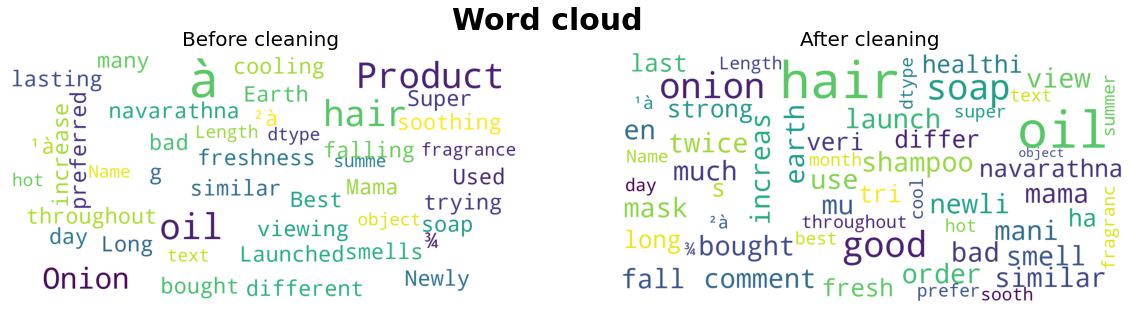

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
wordcloud_plotter(axs[0], data[reviewColName], 'Before cleaning')
wordcloud_plotter(axs[1], dataCleaned[reviewColName], 'After cleaning')
plt.savefig("../working/wordCloud.png")

# All possible combinations of class merging and selection
* For each total number of N classes, i.e., 2, 3, 4, and 5, all possible N selection of classes from the original number of classes (5) has been considered:
 * E.g., for N = 3, some 3-class scenarios are:
      * [1, 2, 3], [1, 2, 4], [1, 2, 5], ...
* Also all possible merging of neighboring classes are considered:
 * E.g., for N = 3, some merged 3-class scenarios are (merged classes are enclosed in parentheses):
     * [(1,2), 3, 4], [1, (2, 3), 4], ... [(1,2,3), 4, 5], ...

In [6]:
# %matplotlib inline 
def class_chooser_helper(tmp, tmp2, clsNb = None):
    """A helper for class_chooser"""
    if clsNb != None:
        jj = clsNb
    elif clsNb == None:
        jj = range(2, len(tmp)+1)
    for j in jj:  
        tmp3 = list(combinations(tmp, j))
        for tmp4 in tmp3:
            tmp2.append(tmp4)
    return tmp2
  
    
def class_chooser(classLabel, clsNb = None):
    """Chooses possible combination of classes"""
    tmp2 = []
    tmp2 = class_chooser_helper(classLabel, tmp2, clsNb)
    for k in range(2,len(classLabel)):
        for i in range(0,len(classLabel)-k+1):
            tmp = []
            tmp.append((classLabel[i:i+k]))
            rest = set(classLabel)-set(classLabel[i:i+k])
            for tmp5 in rest:
                tmp.append(tmp5)
            tmp2 = class_chooser_helper(tmp, tmp2, clsNb)
    tmp2 = set(tmp2)
    classNb = defaultdict(list)
    for tmp in tmp2:
        classNb[len(tmp)].append(tmp)
    return classNb


def ismember(a, b): # https://devpress.csdn.net/python/630459aac67703293080ba45.html
    """Equivalent to MATLAB's ismember function"""
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = True
    return [bind.get(itm, False) for itm in a]  # None can be replaced by any other "not in b" value


def class_merger(dataCleaned, ratingColName, classes):
    addVal = 100 
    flattenedClass = []
    for i in classes:
        if isinstance(i, (Sequence, np.ndarray)): # https://stackoverflow.com/questions/16807011/python-how-to-identify-if-a-variable-is-an-array-or-a-scalar
            for j in i:
                flattenedClass.append(j)
        else:
            flattenedClass.append(i)
    selectedClassesIdx = ismember(dataCleaned[ratingColName], flattenedClass)
    dataCleanedMerged = dataCleaned.loc[selectedClassesIdx, :]
    dataCleanedMerged[ratingOrigColName] = dataCleaned[ratingColName]
    for newClass, oldClass in enumerate(classes):
        dataCleanedMerged = dataCleanedMerged.replace({ratingColName:oldClass}, newClass + addVal)
        dataCleanedMerged = dataCleanedMerged.replace({ratingOrigColName:oldClass}, str(oldClass))
    dataCleanedMerged[ratingColName] -= addVal
    return dataCleanedMerged


def nRowCol_calculator(subplotsNb, subplotsCols = 5):
    if len(subplotsNb) > subplotsCols:
        nCol = subplotsCols
        nRow = math.ceil(len(subplotsNb) / nCol)
    else:
        nCol = len(subplotsNb)
        nRow = 1 
    return nRow, nCol


def plot_parameters(axs, pltIdx, nRow, nCol):
    rows, cols = divmod(pltIdx, nCol) # https://stackoverflow.com/questions/28995146/matlab-ind2sub-equivalent-in-python
    if nRow != 1:
            ax = axs[rows, cols]
    elif nCol != 1:
        ax = axs[cols]
    elif nCol == 1:
        ax = axs    
    if rows+1 == nRow:
        isXlabel = True
    else:
        isXlabel = False
    if cols+1 == 1:
        isYlabel = True
    else:
        isYlabel = False
    return ax, isXlabel, isYlabel


def classSize_plotter(ax, isXlabel, isYlabel, df, df_col, df_colOrig):
    sns.countplot(ax=ax, x = df_col, hue=df_colOrig, data = df, dodge=False)
    if not isXlabel:
        ax.set_xlabel('')
    if not isYlabel:
        ax.set_ylabel('')

    
def classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName):
    nRow, nCol = nRowCol_calculator(classNb[classNbIdx])    
    fig, axs = plt.subplots(nRow, nCol, figsize = (20, 4*nRow)) 
    fig.suptitle('Class size for {}-class classification task'.format(classNbIdx), fontsize= 30, fontweight='bold')
    for pltIdx, classes in enumerate(classNb[classNbIdx]):
        dataCleanedMerged = class_merger(dataCleaned, ratingColName, classes)
        ax, isXlabel, isYlabel = plot_parameters(axs, pltIdx, nRow, nCol)
        classSize_plotter(ax, isXlabel, isYlabel, dataCleanedMerged, ratingColName, ratingOrigColName)
    plt.savefig("../working/{}-classSize.png".format(classNbIdx))

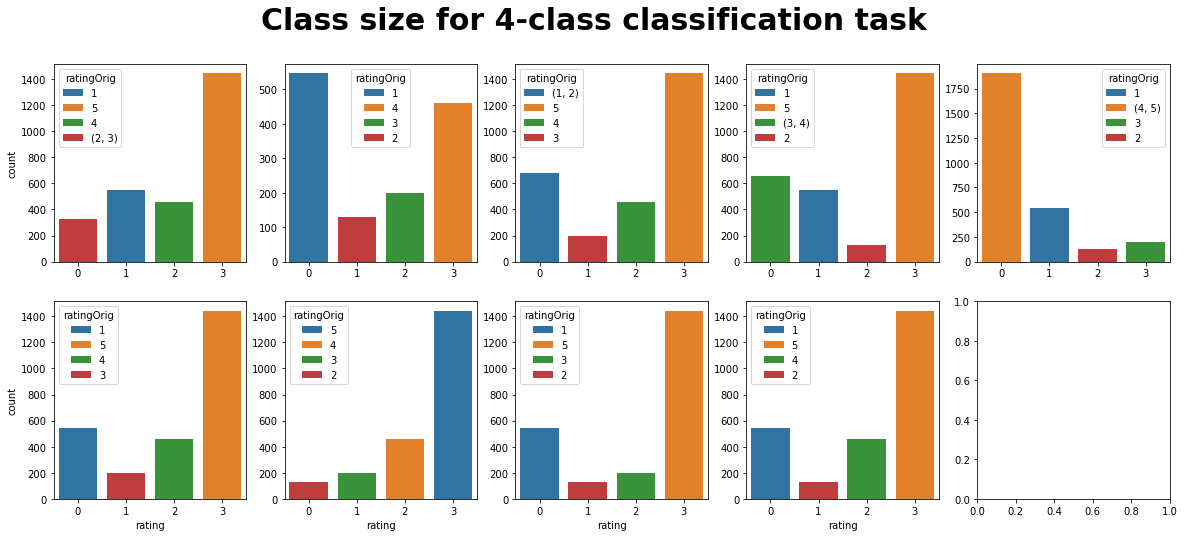

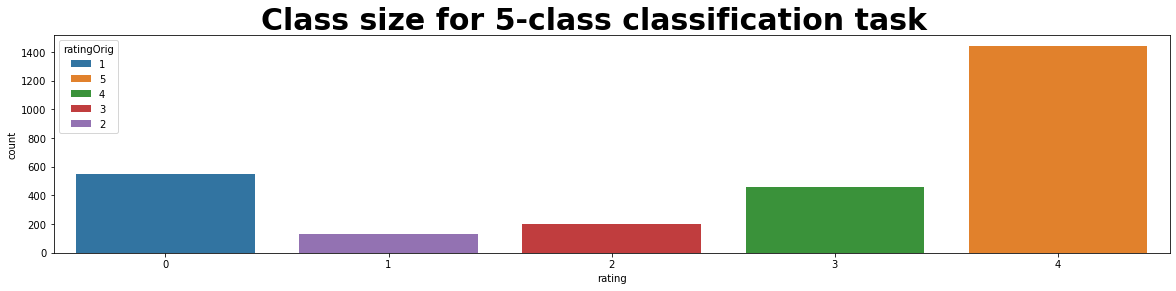

In [7]:
classLabel = tuple(np.unique(dataCleaned[ratingColName]))
classNb = class_chooser(classLabel, clsNb = [4, 5]) # Specify clsNb=None, for general case
for classNbIdx in classNb.keys():
    classSizeTot_plotter(classNb, classNbIdx, dataCleaned, ratingColName)

# Step : Fine-tuned optimal classifier using GridSearchCV
* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    1. Model (pipeline: TF-IDF -> SMOTE -> classifier) is built;
    1. GridSearchCV is applied on a set of classifiers to find their optimal hyper-parameters;
    1. The fine-tuned classifier maximising the GridSearchCV accuracy is selected as the optimal classifier;

In [8]:
def tfidf_instantiator(): 
    TfidfVectorizerParams = {'sublinear_tf':True, 'strip_accents':None, 'lowercase':False, 'preprocessor':None} # To meke sure the same TfidfVectorizer params are used across the code
    tfidf  = TfidfVectorizer(**TfidfVectorizerParams) # sublinear_tf=True
    return tfidf


def smote_instantiator(y): 
    """SMOTE value is equal to the maximum class size"""
    smoteClassSize = pd.Series(np.asarray(y)).value_counts(sort=True).iloc[0] # The resulting object will be in descending order so that the first element is the most frequently-occurring element.
    sampling_strategy = {}
    for i in np.unique(y):
        sampling_strategy[i] = smoteClassSize
    smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy ) #  , k_neighbors = 3
    return smote


def clf_instantiator(clfName):    
    if clfName == "svm":
        clf = svm.SVC(kernel='linear', probability=True, random_state=random_state) 
        param_grid = "?"
    elif clfName == "knn":
        clf = KNeighborsClassifier() 
        param_grid = [{clfParamName+'__'+'n_neighbors': [3, 5, 7, 9],
                           clfParamName+'__'+'weights': ['uniform', 'distance'],
                           clfParamName+'__'+'p': [1, 2]}]
    elif clfName == "lr":
        clf = LogisticRegression(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'penalty': ['l1', 'l2'],
                       clfParamName+'__'+'C': [10.0, 100.0]}] # 0.001, 0.01, 0.1, 1.0,
    elif clfName == "nb":
        clf = BernoulliNB() 
        param_grid = "?"
    return clf, param_grid


def model_builder(y, clfName, clfParamName):    
    tfidf = tfidf_instantiator()        
    smote = smote_instantiator(y)
    if type(clfName) == str: # Grid-search mode: instantiate clf
        clf, param = clf_instantiator(clfName)
    else: # uses previously-computed optimal clf
        clf, param = clfName, None
    model = Pipeline([('tfidf', tfidf), (clfParamName, clf)]) # , ('smote', smote)
    return model, param


def optClf_finder(clfNames, X, y):
    """Finds optimal clf and related params using gridSearchCV"""
    gridSearchCV = {}
    for clfName in clfNames:
        model, param = model_builder(y, clfName, clfParamName)
        gs = GridSearchCV(model, param, scoring='accuracy', cv=n_splits, verbose=2, n_jobs=-1)
        gs.fit(X, y)
        gridSearchCV[clfName] = [gs.best_params_, gs.best_score_]
        print('Best parameter set: {}'.format(gs.best_params_))
        print('CV Accuracy: {}'.format(gs.best_score_))
    acc = []
    for val in gridSearchCV.values():
        acc.append(val[1])
    optClfAcc = np.max(acc)
    optClfName = clfNames[np.argmax(acc)] # Index of classifier with maximum performance in grid search
    optParam = gridSearchCV[optClfName][0]
    optParam2 = {}
    for key, val in optParam.items():
        optParam2[key[len(clfParamName)+2:]] = val
    optClf, _ = clf_instantiator(optClfName) # instantiate the optimal clf
    optClf.set_params(**optParam2) # set the optimal params
    print('optimal clf is {}.'.format(optClfName))
    clear_output(wait=False)
    return optClf, optClfName, optClfAcc


def gridSearch_plotter(optClasses, optClfsName, optClfsAcc, classNbIdx):
    xtickLabel = []
    for i, j in zip(optClasses, optClfsName):
        xtickLabel.append(str(i) + '-' + j)     
    fig, _ = plt.subplots(1, 1, figsize = (20, 4)) 
    fig.suptitle('Grid search accuracy (cv={}) for {}-class classification tasks'.format(n_splits, classNbIdx), fontsize= 30, fontweight='bold')
    plt.plot(optClfsAcc, 'o-')
    plt.xticks(np.arange(len(optClfsAcc)), xtickLabel, rotation=30)
    plt.ylabel('Accuracy')
    plt.xlabel('Optimum classifier per class merging')
    plt.grid()
    plt.savefig("../working/{}-GridSearchAcc.png".format(classNbIdx)) 

In [9]:
clfNames = ['knn', 'lr']
optClfs = defaultdict(list)
optClfsName = defaultdict(list)
optClasses = defaultdict(list)
optClfsAcc = defaultdict(list)
dataCleanedMerged = defaultdict(list)
for classNbIdx in classNb.keys():
    for classes in classNb[classNbIdx]:
        dataMerged = class_merger(dataCleaned, ratingColName, classes)
        dataCleanedMerged[classNbIdx].append(dataMerged)
        optClf, optClfName, optClfAcc = optClf_finder(clfNames, dataMerged[reviewColName], dataMerged[ratingColName])
        optClfs[classNbIdx].append(optClf)
        optClfsName[classNbIdx].append(optClfName)
        optClasses[classNbIdx].append(classes)
        optClfsAcc[classNbIdx].append(optClfAcc)  

## GridSearchCV accuracy comparison across multi-class, i.e., 2-class, ..., 5-class, scenarios

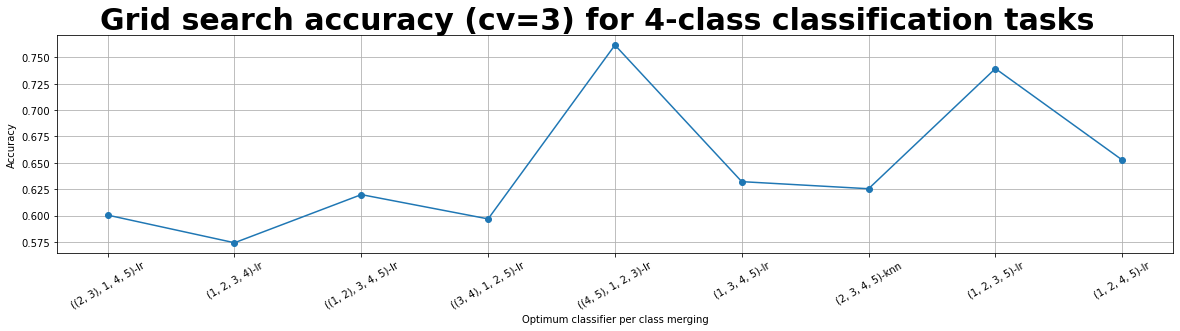

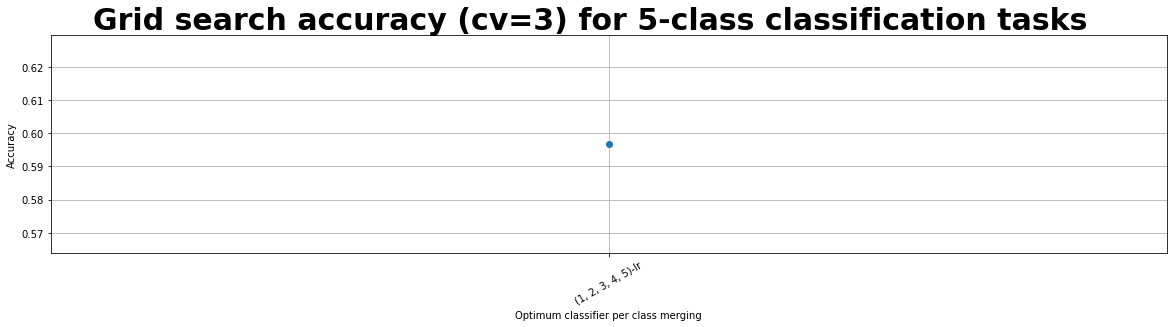

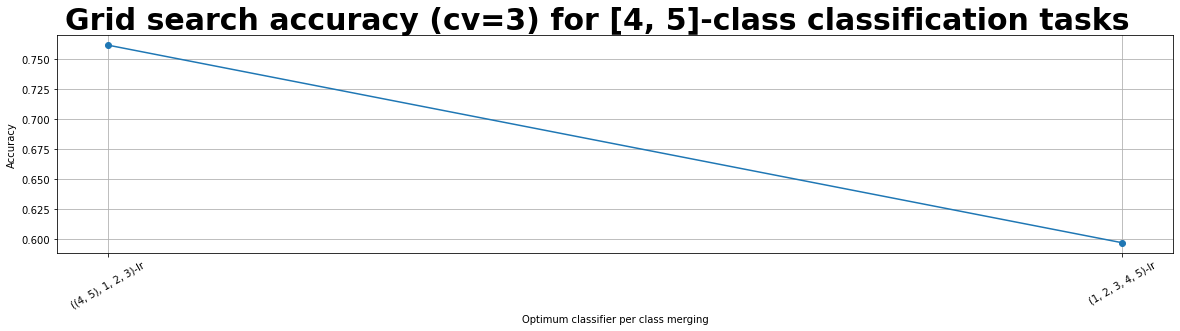

In [10]:
optDataCleanedMerged = []
optClf = []
optClfName = []
optClass = []
optClfAcc = []
for classNbIdx in classNb.keys():   
    gridSearch_plotter(optClasses[classNbIdx], optClfsName[classNbIdx], optClfsAcc[classNbIdx], classNbIdx)    
    optIdx = np.argmax(optClfsAcc[classNbIdx]) # Maximum acc idx across different combinations of the classNbIdx-class classification task
    optDataCleanedMerged.append(dataCleanedMerged[classNbIdx][optIdx])
    optClf.append(optClfs[classNbIdx][optIdx])
    optClfName.append(optClfsName[classNbIdx][optIdx])
    optClass.append(optClasses[classNbIdx][optIdx])
    optClfAcc.append(optClfsAcc[classNbIdx][optIdx])

gridSearch_plotter(optClass, optClfName, optClfAcc, str(list(classNb.keys())))

# Step : Receiver Operating Characteristic ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curves
* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded ROCs) following steps are performed:
        1. training/test dataset split using N*K-fold cross-validation (CV)
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) curve and AUC are computed as an evaluation metric for each CV repetition;
        1. Macro average (following single black curve) is computed across CV repetitions (following multiple coloured curves);
        1. The threshold maximising the geometric mean (G-mean) of sensitivity and specificity is selected as the optimal threshold (to be used at the next step).

In [11]:
def output_binariser(X, Y, classLabel):
    """Binarize the output"""
    y_binary = label_binarize(Y, classes=classLabel)
    X_binary, Y_binary = [], []
    for i in range(y_binary.shape[1]): 
        Xrsmp, Yrsmp = X, y_binary[:, i]
        X_binary.append(Xrsmp)
        Y_binary.append(Yrsmp)
    return X_binary, Y_binary


def idx_finder_micro(classNb):
    idx = []
    for i in range(n_repeats*n_splits):
        idx.append(np.asarray(list(range((classNb-1)*X_test.shape[0], classNb*X_test.shape[0]))) + i * (n_classes-1)*X_test.shape[0])
    idx = np.hstack(idx)
    return idx


def fpr_unique_finder(n_classes, classNb, fpr_all):
    idx = list(range((classNb-1), n_classes * n_repeats*n_splits, n_classes))
    fprSel = []
    for i in idx:
        fprSel.append(fpr_all[i])
    fprUnique = np.unique(np.concatenate(np.asarray(fprSel)))
    return fprUnique


def microAvg_calc(n_classes, y_test_all_ravel, y_score_all):
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()    
    for i in range(n_classes):
        micro_tmp = "micro_{}".format(i+1)
        fpr[micro_tmp], tpr[micro_tmp], _ = roc_curve(y_test_all_ravel[idx_finder_micro(i+1)], y_score_all[idx_finder_micro(i+1)])
        roc_auc[micro_tmp] = auc(fpr[micro_tmp], tpr[micro_tmp])  
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_ravel, y_score_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc


def roc_bestThr(tpr, fpr, thr, fieldName):
#     https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    roc_auc = {}
    gmeans = np.sqrt(tpr * (1-fpr)) # calculate the g-mean for each threshold
    roc_auc["{}BestThrIdx".format(fieldName)] = np.argmax(gmeans) # locate the index of the largest g-mean
    roc_auc["{}BestThrVal".format(fieldName)] = thr[roc_auc["{}BestThrIdx".format(fieldName)]] 
    roc_auc["{}BestThrGmeans".format(fieldName)] = gmeans[roc_auc["{}BestThrIdx".format(fieldName)]]
    return roc_auc


def macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds):
    # First aggregate all false positive rates
    fpr_unique_perClass = []
    for i in range(n_classes):
        fpr_unique_perClass.append(fpr_unique_finder(n_classes, i+1, fpr_all))  
    fpr_unique = np.unique(np.concatenate(fpr_all))
    mean_tpr_perClass = {}
    for j in range(n_classes):
        mean_tpr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
    mean_tpr = np.zeros_like(fpr_unique)
    mean_thr_perClass = {}
    for j in range(n_classes):
        mean_thr_perClass[j] = np.zeros_like(fpr_unique_perClass[j])
    mean_thr = np.zeros_like(fpr_unique)
    for i in range(n_classes):
        for j in range(n_repeats*n_splits):
            mean_tpr += interp(fpr_unique, fpr[i][j], tpr[i][j])
            mean_tpr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], tpr[i][j])
            mean_thr += interp(fpr_unique, fpr[i][j], thresholds[i][j])
            mean_thr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], thresholds[i][j])
    # Finally average it and compute AUC
    mean_tpr /= (n_classes * n_repeats*n_splits)
    mean_thr /= (n_classes * n_repeats*n_splits)
    for i in range(n_classes):
        mean_tpr_perClass[i] /= (n_repeats*n_splits)
        mean_thr_perClass[i] /= (n_repeats*n_splits)

    roc_auc = dict()
    for i in range(n_classes):
        macro_tmp = "macro_{}".format(i+1)                         
        fpr[macro_tmp], tpr[macro_tmp] = np.hstack([0, fpr_unique_perClass[i], 1]), np.hstack([0, mean_tpr_perClass[i], 1])
        
        roc_auc_ = roc_bestThr(tpr[macro_tmp], fpr[macro_tmp], mean_thr_perClass[i], macro_tmp)
        roc_auc.update(roc_auc_)
    
        roc_auc[macro_tmp] = auc(fpr[macro_tmp], tpr[macro_tmp])

    fpr["macro"], tpr["macro"] = np.hstack([0, fpr_unique, 1]), np.hstack([0, mean_tpr, 1])
    roc_auc_ = roc_bestThr(tpr["macro"], fpr["macro"], mean_thr, "macro")
    roc_auc.update(roc_auc_)
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])                                 
    return fpr, tpr, roc_auc


def split_feature_clf_cv(X, y, clf, n_splits, n_repeats):
    """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) 
    acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot = [], [], [], [], [], [], []
    for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] # train/test split
        model, _ = model_builder(y_train, clf, '')
        model.fit(X_train, y_train)                 
        if len(np.unique(y)) == 2: # If binary task  
            y_score = model.predict_proba(X_test)[:, 1]
            fpr_, tpr_, thr_ = roc_curve(y_test, y_score) 
            auc__ = auc(fpr_, tpr_)
        else:
            fpr_, tpr_, thr_, auc__, y_score = np.nan, np.nan, np.nan, np.nan, np.nan
        acc.append(model.score(X_test, y_test)) # Classifier acc         
        fpr.append(fpr_)
        tpr.append(tpr_)
        thr.append(thr_)
        auc_.append(auc__)
        y_testTot.append(y_test)
        y_scoreTot.append(y_score)
    y_testTot, y_scoreTot = np.hstack(y_testTot), np.hstack(y_scoreTot)
    return acc, fpr, tpr, thr, auc_, y_testTot, y_scoreTot


def negClass_finder(classLabel, classLabelTot, origNew):
    theRest = list(set(classLabelTot) - set([classLabel]))
    theRestTot = []
    for i in theRest:
        theRestTot.append(origNew[i])
    return ','.join(theRestTot)


def rocRpt_plotter(ax, classLabelTot, fpr, fprMacro, tpr, tprMacro, aucMacro, 
                   aucBestThrIdx, aucBestThrGMean, color, lw, classLabel, isYlabel, origNew, ylabel):
    for j in range(len(fpr)): 
        if j == 1:
            ax.plot(fpr[j], tpr[j], color=color, lw=lw, label='Classes {}'.format(origNew[classLabel]), alpha=1) # 
        ax.plot(fpr[j], tpr[j], color=color, lw=lw) # , alpha=0.5

    ax.plot(fprMacro, tprMacro, 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                 .format(aucMacro))
    ax.scatter(fprMacro[aucBestThrIdx], tprMacro[aucBestThrIdx], marker='o', color='k', s=2**7, zorder=20,
                    label='Opt (GM = {0:0.2f})'.format(aucBestThrGMean))  
    theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
    rocAxis_plotter(ax, lw, ylabel, "Pos. label : {} \n Neg. labels : {}".format(origNew[classLabel], theRestTot))


def rocAxis_plotter(ax, lw, ylabel=None, title=None):
    ax.axis('square')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
    ax.axis([-0.05, 1.0, 0.0, 1.05])
    ax.set_ylabel(ylabel, fontsize=12)  
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax.set_title (title, fontdict = {'size':12}) # , pad = 20 
    ax.legend(loc="lower right")
    ax.grid() 
    
    
def origNewLabel_finder(origLabel, newLabel): 
    newLabelUnique = np.unique(newLabel)
    origNew = {}
    for i in newLabelUnique:
        origNew[i]= origLabel[newLabel == i][0]
    return origNew
    
    
def rocTot_plotter(optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw):
    YOrig = optDataCleanedMerged[ratingOrigColName].values
    X = optDataCleanedMerged[reviewColName].values
    y = optDataCleanedMerged[ratingColName].values
    origNew = origNewLabel_finder(YOrig, y)
    classLabel = list(np.unique(y))    
    X_binary, Y_binary = output_binariser(X, y, classLabel)
    n_classes = len(classLabel)
#     clf = OneVsRestClassifier(clf)    
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,5), sharey=True, sharex=True)
    fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(n_classes, n_repeats, n_splits), #  performance evaluation technique
                fontsize=20, fontweight='bold')          
    fpr_models = [] #dict()
    acc, fpr, tpr, thr, auc_ = {}, {}, {}, {}, {}
    y_testTot, y_scoreTot, fprTot = [], [], []
    for i, (X, y) in enumerate(zip(X_binary, Y_binary)):
        acc[i], fpr[i], tpr[i], thr[i], auc_[i], y_testTot_, y_scoreTot_ = split_feature_clf_cv(X, y, clf, n_splits, n_repeats)
        y_testTot.append(y_testTot_)
        y_scoreTot.append(y_scoreTot_)
        fprTot.append(fpr[i])
    y_testTot, y_scoreTot, fprTot = np.hstack(y_testTot), np.hstack(y_scoreTot), np.hstack(fprTot)
    fpr_macro, tpr_macro, roc_auc_macro = macroAvg_calc(n_classes, n_repeats, n_splits, fprTot, fpr, tpr, thr)                            
    fpr.update(fpr_macro)
    tpr.update(tpr_macro)
    auc_.update(roc_auc_macro)

    # Plot all ROC curves  
    for i in range(n_classes):
        if i == 0:
            ylabel = '{} \n True Positive Rate (TPR)'.format(clfName)
        else:
            ylabel = None
        rocRpt_plotter(ax[i], classLabel, fpr[i], fpr["macro_{}".format(i+1)], tpr[i], tpr["macro_{}".format(i+1)], auc_["macro_{}".format(i+1)], 
        auc_["macro_{}BestThrIdx".format(i+1)], auc_["macro_{}BestThrGmeans".format(i+1)], 
                       colors_classes[i], lw, classLabel[i], i==0, origNew, ylabel)
    for i in range(n_classes):
        ax[n_classes].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], colors_classes[i], lw=lw, 
                   label='Class {0} (AUC = {1:0.2f})'.format(origNew[classLabel[i]], auc_["macro_{}".format(i+1)]))        
    ax[n_classes].plot(fpr["macro"], tpr["macro"], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                     .format(auc_["macro"]))
    ax[n_classes].scatter(fpr["macro"][auc_["macroBestThrIdx"]], 
                         tpr["macro"][auc_["macroBestThrIdx"]], 
                         marker='o', color='k', s=2**7, zorder=20,
                            label='Opt (GM = {0:0.2f})'.format(auc_["macroBestThrGmeans"]))
    rocAxis_plotter(ax[n_classes], lw, ylabel=None, title='Across classes')
    fpr_models = fpr, tpr, auc_
    plt.savefig("../working/{}-classROC.png".format(n_classes))
    return fpr_models

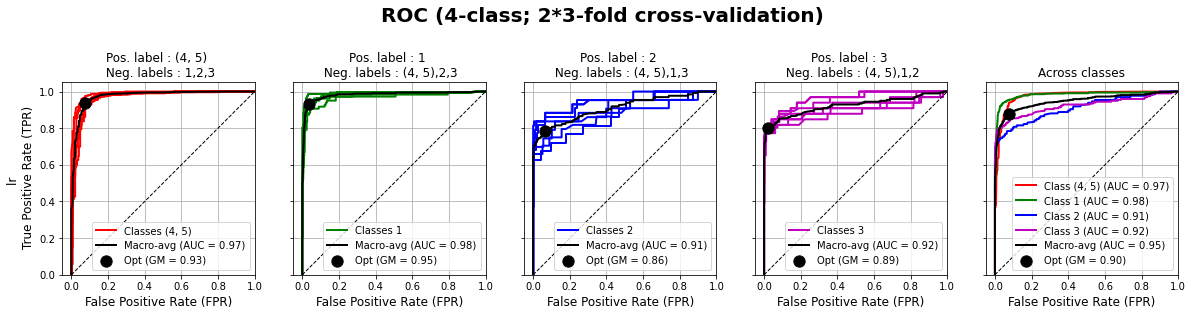

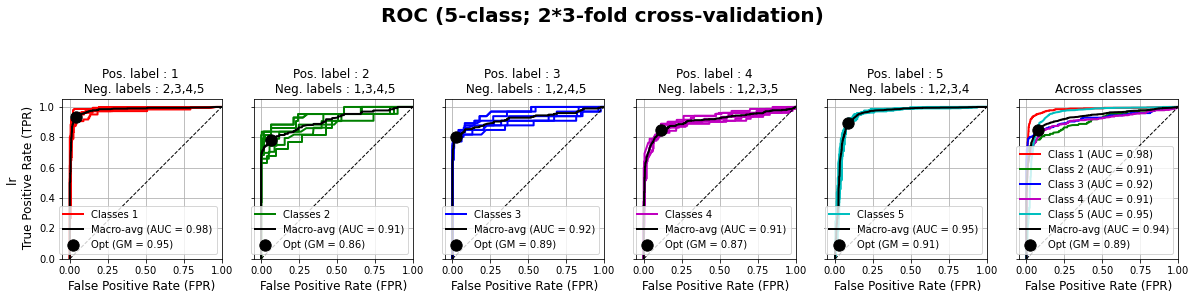

In [12]:
lw = 2 # Line width
colors_classes = ['r', 'g', 'b','m', 'c']
fpr_models = []
for dataCleanedMergedTmp, classTmp, clfName, clf in zip(optDataCleanedMerged, optClass, optClfName, optClf):
    fpr_model = rocTot_plotter(dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf, lw)
    fpr_models.append(fpr_model)


## Macro-averaged ROC comparison across multi-class, i.e., 2-class, ..., 5-class, scenarios

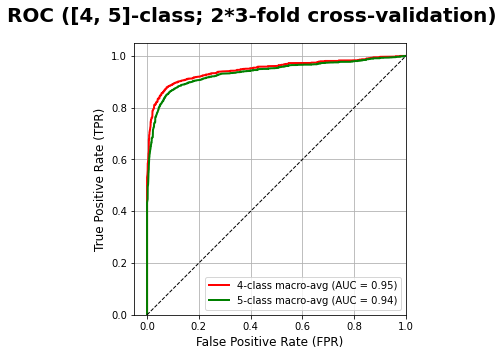

In [13]:
fprIdx, tprIdx, aucIdx = 0, 1, 2
classNbList = list(classNb.keys())
fig, ax = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('ROC ({}-class; {}*{}-fold cross-validation)'.format(str(classNbList), n_repeats, n_splits), #  performance evaluation technique
            fontsize=20, fontweight='bold')  
for i in range(len(fpr_models)):
    ax.plot(fpr_models[i][fprIdx]["macro"], fpr_models[i][tprIdx]["macro"], colors_classes[i], lw=lw, 
                   label='{0}-class macro-avg (AUC = {1:0.2f})'.format(classNbList[i], fpr_models[i][aucIdx]["macro"]))        
rocAxis_plotter(ax, lw, 'True Positive Rate (TPR)')

# Step : ROC-obtained optimal threshold is used for the final model
* For each multi-class scenario, i.e., 2-class, ..., 5-class, the following procedure is repeated:
    * Multi-class labels are binarised, i.e., One-vs-rest (OvR), and for each binary label vector (the following colour-coded confusion matrices) following steps are performed:
        1. Model (pipeline: TF-IDF -> SMOTE -> fine-tuned classifier) is trained on the training dataset;
        1. Trained model is scored on the test dataset;
        1. The scores are thresholded based on the optimal threshold obtained from the corresponding ROC;
        1. Confusion matrix is computed as an evaluation metric.
    * The above steps, except for the third step, i.e., scores thresholding, are also repeated for the multi-class task (the following grey-coded confusion matrix).

## Confuison/Error matrix
* The confusion matrix is a performance evaluation technique in a classification task (per-category comparison of the predicted labels to the true labels). 
* The standard/conventional confusion matrix is computed for a binary classification task (Negative and Positive labels).
* Correctly-classified samples are either True Positive or True Negative, while the mis-classified ones are either called False Positive or False Negative.
* Some useful evaluation metrics that can be derived from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) are:
 * True Positive Rate (TPR), or sensitivity, or recall, or hit rate;
 * Positive Predictive Value (PPV) or precision;
 * F1 score (the harmonic mean of precision and sensitivity);
 * Accuracy (ACC). 

In [14]:
def confusionMatrix_plotter(ax, cf_matrix, classLabel, classLabelTot, origNew, colors_classes_CF, ylabel=None):
    ax.axis('square')
    cf_dim = len(cf_matrix)
    group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.ravel() / np.sum(cf_matrix)]
    if cf_dim == 2: #OvR
        group_names = ['TN','FP',"FN", 'TP']
        theRestTot = negClass_finder(classLabel, classLabelTot, origNew)
        categories  = [theRestTot, origNew[classLabel]] # group_names = ['b']*(cf_dim**2)
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    else: # Multiclass
        categories = []
        for i in classLabelTot:
            categories.append(origNew[i])
        labels = group_percentages
    labels = np.asarray(labels).reshape(cf_dim, cf_dim)        
    cmap = colors_classes_CF
    h = sns.heatmap(cf_matrix, ax=ax, annot = labels, cmap = cmap,fmt = '',
                xticklabels = categories, yticklabels = categories, cbar_kws={"shrink": 0.5})
    ax.set_ylim(cf_dim, 0)
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')    
    if cf_dim == 2:
        tn, fp, fn, tp = cf_matrix.ravel()
        tpr = tp / (tp + fn)
        ppv = tp / (tp + fp)  
        f1 = 2 * (ppv*tpr)/(ppv+tpr)
        acc = (tp + tn) / (tp + tn + fn + fp)
    else: # cf_dim == n_classes:
        acc = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
        tpr = np.nan
        ppv = np.nan 
        f1 = np.nan         
    ax.set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
    ax.set_ylabel(ylabel, fontdict = {'size':12}) # , labelpad = 10     
        
    if cf_dim == 2: #classLabel != None: # Binary        
        ax.set_title ("Neg. labels: {0} \nPos. label: {1}\nTPR={2:.1%}, PPV={3:.1%}\nF1={4:.1%}, ACC={5:.1%}".
                      format(theRestTot, origNew[classLabel], tpr, ppv, f1, acc), 
                                    fontdict = {'size':12}) # , pad = 20
    else: # Multiclass
        ax.set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12})
    

def split_feature_clf_confusion(X, y, test_size, clf, thr):
    """Splits into train/test; extracts features; trains & tests the classifier. Returns average test confusion matrix."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # train/test split
    model, _ = model_builder(y_train, clf, '')
    model.fit(X_train, y_train)                 
    if len(np.unique(y)) == 2: # If binary task  
        y_score = model.predict_proba(X_test)[:, 1]
        y_score[y_score >= thr] = 1
        y_score[y_score < thr] = 0
    else:
        y_score = model.predict(X_test)
    return confusion_matrix(y_test, y_score)


def confusionTot_plotter(fpr_model, optDataCleanedMerged, reviewColName, ratingColName, ratingOrigColName, clfName, clf, colors_classes_CF):
    yOrig, X, y = optDataCleanedMerged[ratingOrigColName].values, optDataCleanedMerged[reviewColName].values, optDataCleanedMerged[ratingColName].values
    origNew = origNewLabel_finder(yOrig, y)
    classLabelTot = list(np.unique(y))    
    X_binary, Y_binary = output_binariser(X, y, classLabelTot)
    n_classes = len(classLabelTot)    
    clf = OneVsRestClassifier(clf)
    # fig, ax = plt.subplots(n_models, n_classes+1, figsize=(20,6*(n_models))) # , sharey=True, sharex=True
    fig, ax = plt.subplots(1, n_classes+1, figsize=(20,5)) # , sharey=True, sharex=True
    fig.suptitle('{}-class: Confusion matrix for the optimum threshold on the ROC'.format(n_classes), fontsize=20, fontweight='bold') 
    for i, classLabel in enumerate(classLabelTot):
        thr = fpr_model[aucIdx]["macro_{}BestThrVal".format(i+1)]     
        cfMatrix = split_feature_clf_confusion(X_binary[i], Y_binary[i], test_size, clf, thr)
        if i == 0:
            ylabel = "{} \n Actual values".format(clfName)
        else:
           ylabel = None 
        confusionMatrix_plotter(ax[i], cfMatrix, classLabel, classLabelTot, origNew, colors_classes_CF[i], ylabel) 
    cfMatrix = split_feature_clf_confusion(X, y, test_size, clf, None)
    confusionMatrix_plotter(ax[n_classes], cfMatrix, None, classLabelTot, origNew, 'Greys', None)         
    plt.savefig("../working/{}-classConfusion.png".format(n_classes))

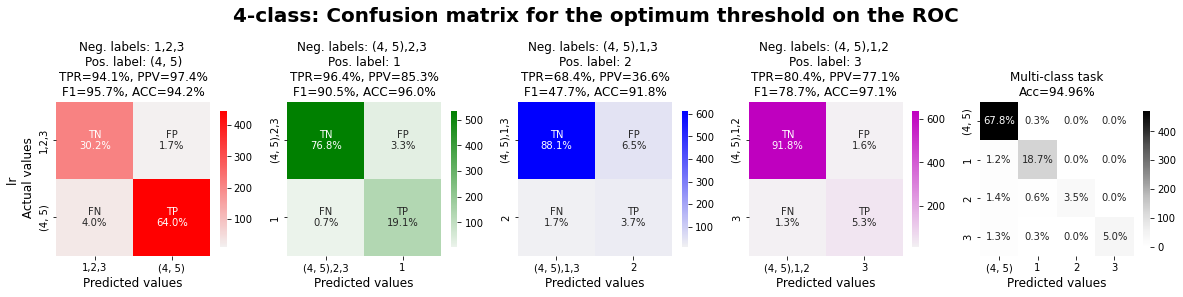

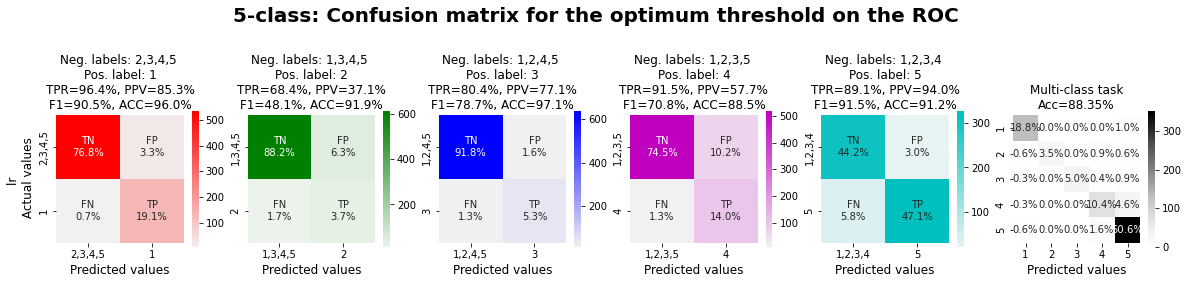

In [15]:
test_size = 0.25
colors_classes_CF = []
for colors_classe in colors_classes:
    colors_classes_CF.append(sns.light_palette(colors_classe, as_cmap=True))
for fpr_model, dataCleanedMergedTmp, classTmp, clfName, clf in zip(fpr_models, optDataCleanedMerged, optClass, optClfName, optClf):
    confusionTot_plotter(fpr_model, dataCleanedMergedTmp, reviewColName, ratingColName, ratingOrigColName, clfName, clf, colors_classes_CF)